In [6]:
import pandas as pd
import numpy as np
import json

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.decomposition import TruncatedSVD

from keras.models import Sequential
from keras.layers import Dropout
from keras.layers import  Dense, Embedding, Bidirectional, GRU

import tensorflow as tf

import matplotlib.pyplot as plt

np.random.seed(500)

In [7]:
NUMBER_OF_RECORDS = 50000

ndc_codes = pd.read_csv('../../data/processed/ndc_codes_extracted.csv', dtype=object)['NDC'].to_list()
df = pd.read_csv(
    '../../data/processed/NOTEEVENTS_ML_DATASET.csv', dtype=object, nrows=NUMBER_OF_RECORDS)

In [8]:
drug_orders =  list(map(lambda x: " ".join(eval(x)), df['TEXT_NORMALIZED_ARRAY'].to_list()))[:NUMBER_OF_RECORDS]

multi_class_labels = list(map(lambda x: json.loads(x), df['LABELS'].to_list()))[
    :NUMBER_OF_RECORDS]

y = list(map(lambda x: x[1], multi_class_labels))

NUMBER_OF_CLASSES = len(multi_class_labels[0])


In [9]:
# Vectorize drug_orders
vectorizer = TfidfVectorizer(analyzer='word')
drug_order_vectors = vectorizer.fit_transform(drug_orders)

print("TFIDF Shape", drug_order_vectors.shape)

TFIDF Shape (50000, 1520311)


In [10]:
NUMBER_OF_FEATURES = 20

pca = TruncatedSVD(n_components=NUMBER_OF_FEATURES)
result = pca.fit_transform(drug_order_vectors)

print("TSVD Shape", result.shape)

TSVD Shape (50000, 20)


In [11]:
x_train, x_test, y_train, y_test = train_test_split(
        result, y, test_size=0.3, random_state=100)
y_test = np.array(y_test)
y_train = np.array(y_train)

In [12]:
hidden_state_dimensions = [32, 64, 128]
n_unique_words = 200

history_array = []

def train_model(hidden_state, batch_size=32, epoch=3):
    model = Sequential()
    model.add(Embedding(n_unique_words, 128, input_length=NUMBER_OF_FEATURES))
    model.add(Bidirectional(GRU(hidden_state)))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation=tf.nn.tanh))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    history=model.fit(x_train, y_train,
           batch_size=32,
           epochs=3,
           validation_data=[x_test, y_test])
    print(history.history['loss'])
    print(history.history['accuracy'])

    return history

In [13]:
for hidden_state in hidden_state_dimensions:
    history_array.append(train_model(hidden_state=hidden_state))

2022-05-07 23:07:50.539917: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/3
1094/1094 [==============================] - 11s 8ms/step - loss: 0.5639 - accuracy: 0.7552 - val_loss: 0.5578 - val_accuracy: 0.7545
Epoch 2/3
1094/1094 [==============================] - 9s 8ms/step - loss: 0.5604 - accuracy: 0.7552 - val_loss: 0.5584 - val_accuracy: 0.7545
Epoch 3/3
1094/1094 [==============================] - 9s 8ms/step - loss: 0.5594 - accuracy: 0.7552 - val_loss: 0.5575 - val_accuracy: 0.7545
[0.563852846622467, 0.560411274433136, 0.5593572854995728]
[0.7552000284194946, 0.7552000284194946, 0.7552000284194946]
Epoch 1/3
1094/1094 [==============================] - 15s 12ms/step - loss: 0.5665 - accuracy: 0.7552 - val_loss: 0.5612 - val_accuracy: 0.7545
Epoch 2/3
1094/1094 [==============================] - 12s 11ms/step - loss: 0.5604 - accuracy: 0.7552 - val_loss: 0.5573 - val_accuracy: 0.7545
Epoch 3/3
1094/1094 [==============================] - 12s 11ms/step - loss: 0.5595 - accuracy: 0.7552 - val_loss: 0.5583 - val_accuracy: 0.7545
[0.566547453403

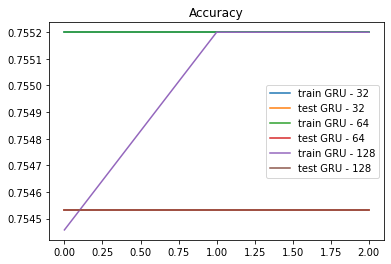

In [15]:
plt.title('Accuracy')

for i in range(len(history_array)):
    history = history_array[i]

    plt.plot(history.history['accuracy'], label='train GRU - ' + str(hidden_state_dimensions[i]))
    plt.plot(history.history['val_accuracy'], label='test GRU - ' + str(hidden_state_dimensions[i]))
    
plt.legend()
plt.show();


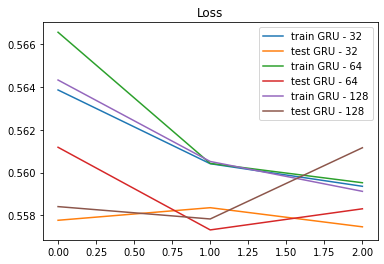

In [16]:
plt.title('Loss')

for i in range(len(history_array)):
    history = history_array[i]

    plt.plot(history.history['loss'], label='train GRU - ' + str(hidden_state_dimensions[i]))
    plt.plot(history.history['val_loss'], label='test GRU - ' + str(hidden_state_dimensions[i]))

plt.legend()
plt.show();